This notebook trains a visual recognition model that can classify between HotDogs and NotHotDogs following the scene in Silicone Valley [link](https://youtu.be/ACmydtFDTGs?si=XSK1L9nGNLKS25QE)

The training data is taken from Kaggle [link](https://www.kaggle.com/datasets/dansbecker/hot-dog-not-hot-dog/)

First, I train a simple model that uses just the dataset. As expected, the accuracy is quite low due to very few examples used for training. 

Next, I use transfer learning and Imagenet pre-trained model. After 15 epochs of training the model has around 95% of in-sample accuracy and 93%+ out-of-sample accuracy. 

The results can be tested using .jpeg pictures. For start, there are a couple of pictures in example/ folder.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import kaggle
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os

%matplotlib inline

# Get Data

The code below requires having kaggle.json file that can be obtained from Kaggle -> Profile -> Create New Token. The kaggle package can be installed via ```pip install kaggle```

In [ ]:
# Uncomment to download
#! kaggle datasets download -d dansbecker/hot-dog-not-hot-dog
# Unzip
# with ZipFile("./hot-dog-not-hot-dog.zip", 'r') as zObject: 
#       zObject.extractall( 
#         path="./data/") 

# Data exploration

Let's examine a couple of files.

In [2]:
data_dir = "./data"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

print("Folders inside data/ folder",os.listdir(data_dir))
print("Folders inside data/train folder",os.listdir(train_dir))
print("Folders inside data/test folder",os.listdir(test_dir))


Folders inside data/ folder ['test', 'seefood', 'train']
Folders inside data/train folder ['not_hot_dog', 'hot_dog']
Folders inside data/test folder ['not_hot_dog', 'hot_dog']


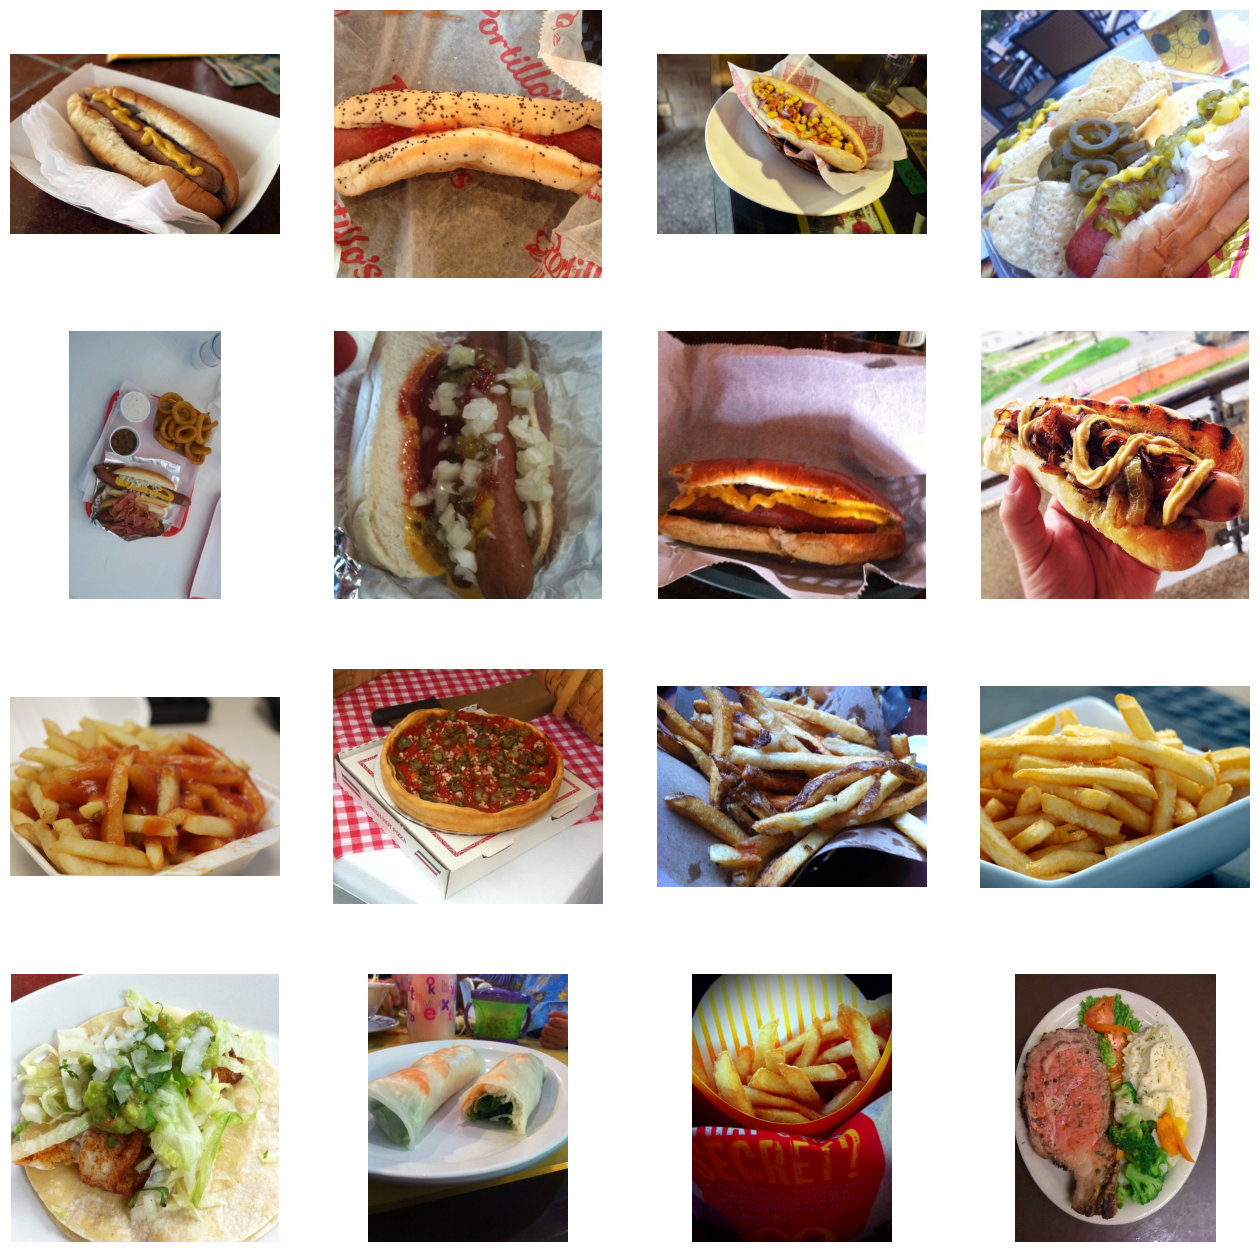

In [3]:
# Setup
pic_indx = 0 # We start with picture 0 and show 8
ncols = 4
nrows = 4 # We will show them as 4x4

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_indx+=8

hotdog = [os.path.join(train_dir,'hot_dog', fname) 
                for fname in os.listdir(os.path.join(train_dir,'hot_dog'))[ pic_indx-8:pic_indx] 
               ]

not_hotdog = [os.path.join(train_dir,'not_hot_dog', fname) 
                for fname in os.listdir(os.path.join(train_dir,'not_hot_dog'))[ pic_indx-8:pic_indx] 
               ]

for i, img_path in enumerate(hotdog+not_hotdog):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

# Train a simple model

We use the train set to train a simple convolutional neural network (CNN). 

In [4]:
# Automatically create sets with labels

train_gen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_gen  = ImageDataGenerator(rescale = 1.0/255. )

train_gen = train_gen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(300, 300))     
test_gen =  test_gen.flow_from_directory(test_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (300, 300))

Found 498 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [5]:
# CNN with simple architecture

model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), input_shape=(300,300,3), activation='relu'),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

2023-10-06 10:19:03.316134: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-06 10:19:03.316159: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-06 10:19:03.316168: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-06 10:19:03.316271: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-06 10:19:03.316574: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 128)       0

In [6]:
model.compile(optimizer=keras.optimizers.legacy.RMSprop(learning_rate=0.001), # legacy to run on M1 Mac
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [7]:
report = model.fit(
            train_gen,
            epochs=15,
            validation_data=test_gen,
            verbose=2
            )

Epoch 1/15


2023-10-06 10:19:15.834794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


25/25 - 10s - loss: 14.4383 - accuracy: 0.5201 - val_loss: 1.6816 - val_accuracy: 0.5000 - 10s/epoch - 415ms/step
Epoch 2/15
25/25 - 7s - loss: 0.7943 - accuracy: 0.5301 - val_loss: 2.1088 - val_accuracy: 0.5000 - 7s/epoch - 291ms/step
Epoch 3/15
25/25 - 7s - loss: 1.7088 - accuracy: 0.4980 - val_loss: 2.5876 - val_accuracy: 0.5000 - 7s/epoch - 278ms/step
Epoch 4/15
25/25 - 7s - loss: 1.0947 - accuracy: 0.5181 - val_loss: 0.7295 - val_accuracy: 0.4900 - 7s/epoch - 276ms/step
Epoch 5/15
25/25 - 7s - loss: 0.9841 - accuracy: 0.4799 - val_loss: 0.7215 - val_accuracy: 0.4860 - 7s/epoch - 284ms/step
Epoch 6/15
25/25 - 7s - loss: 1.0123 - accuracy: 0.4900 - val_loss: 0.7477 - val_accuracy: 0.5160 - 7s/epoch - 279ms/step
Epoch 7/15
25/25 - 7s - loss: 0.7921 - accuracy: 0.5602 - val_loss: 0.7184 - val_accuracy: 0.5540 - 7s/epoch - 267ms/step
Epoch 8/15
25/25 - 7s - loss: 0.7002 - accuracy: 0.5863 - val_loss: 0.8270 - val_accuracy: 0.5020 - 7s/epoch - 280ms/step
Epoch 9/15
25/25 - 7s - loss: 0.

Examine accuracy and loss as a function of epochs.

Text(0.5, 1.0, 'Training and validation loss')

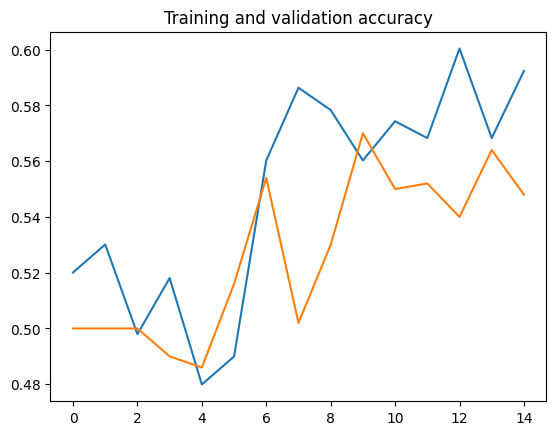

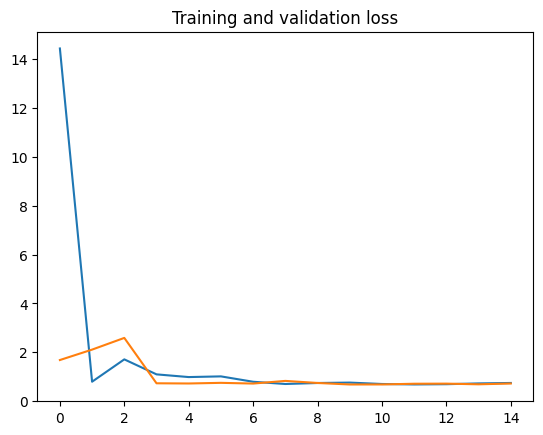

In [8]:
acc = report.history['accuracy']
val_acc = report.history['val_accuracy']
loss = report.history['loss']
val_loss = report.history['val_loss']

epochs = range(len(acc)) 

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()


plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Looks quite volatile. The training sample is clearly too small. 

# Transfer learning

Next, we use Imagenet pre-trained CNN model for transfer learning. 

In [9]:
# Import Imagenet pretrained model
base_model = keras.applications.Xception(
    weights='imagenet',  
    input_shape=(300, 300, 3),
    include_top=False) 

In [10]:
# Freeze the model
base_model.trainable = False

In [11]:
# Add layers

inputs = keras.Input(shape=(300, 300, 3))

x = base_model(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
model = keras.Model(inputs, outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 20863529 (79.59 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [13]:
model.compile(optimizer=keras.optimizers.legacy.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
report = model.fit(train_gen, epochs=15, validation_data=test_gen)

Epoch 1/15


/Users/mike/Documents/MyGit/HotDog/env/lib/python3.9/site-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


25/25 [==============================] - 13s 491ms/step - loss: 0.4785 - binary_accuracy: 0.8655 - val_loss: 0.3383 - val_binary_accuracy: 0.8960
Epoch 2/15
25/25 [==============================] - 12s 464ms/step - loss: 0.3132 - binary_accuracy: 0.9036 - val_loss: 0.2571 - val_binary_accuracy: 0.9240
Epoch 3/15
25/25 [==============================] - 12s 463ms/step - loss: 0.2588 - binary_accuracy: 0.9157 - val_loss: 0.2300 - val_binary_accuracy: 0.9080
Epoch 4/15
25/25 [==============================] - 12s 462ms/step - loss: 0.2306 - binary_accuracy: 0.9217 - val_loss: 0.2149 - val_binary_accuracy: 0.9160
Epoch 5/15
25/25 [==============================] - 12s 463ms/step - loss: 0.2179 - binary_accuracy: 0.9317 - val_loss: 0.2020 - val_binary_accuracy: 0.9320
Epoch 6/15
25/25 [==============================] - 12s 463ms/step - loss: 0.2039 - binary_accuracy: 0.9277 - val_loss: 0.2027 - val_binary_accuracy: 0.9180
Epoch 7/15
25/25 [==============================] - 12s 463ms/step - 

Text(0.5, 1.0, 'Training and validation loss')

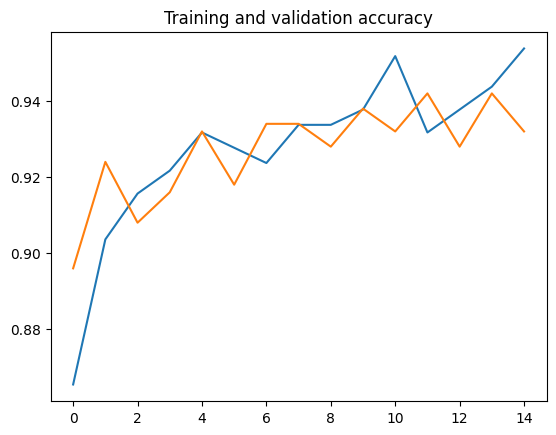

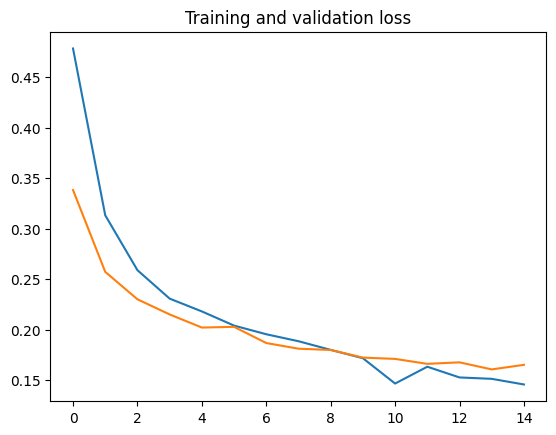

In [14]:
acc = report.history['binary_accuracy']
val_acc = report.history['val_binary_accuracy']
loss = report.history['loss']
val_loss = report.history['val_loss']

epochs = range(len(acc)) 

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()


plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Much better accuracy. 

# Widget

Let's build a widget to deploy the model.

Run the upload cell to upload an image file. Run the next cell to get the result.

In [15]:
import ipywidgets as widgets

uploader = widgets.FileUpload(multiple=False, accept='image/*')


    
display(uploader)



FileUpload(value=(), accept='image/*', description='Upload')

1/1 [==============================] - 1s 662ms/step


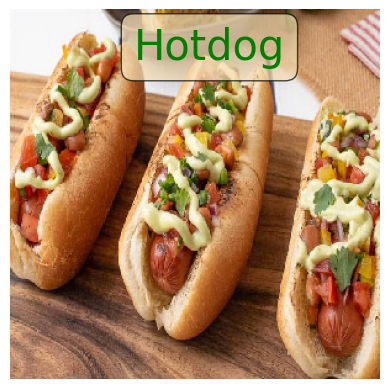

In [16]:
import io
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
from PIL import Image

# Plot
def PictureShow(imp, x, y, result, clr):
    fig = plt.figure()
    plt.imshow(img)

    plt.text(x, y, result, dict(size=30, color=clr), bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    plt.axis('off')
    plt.show()
    
# Prepare data
image_data = uploader.value[0].content.tobytes() # byte values of the image
img = load_img(io.BytesIO(image_data), target_size=(300,300))
x = img_to_array(img)
x = x/255.
x = np.expand_dims(x, axis=0)

# Make and interpret prediction
classes = model.predict(x)

if classes[0]<0.5:
    result = 'Hotdog'
    PictureShow(img, 100, 40, result, 'green')
    
    
else:
    result = 'Not Hotdog'
    PictureShow(img, 50, 250, result, 'red')


